Configuração Inicial

In [17]:
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Inicialização da sessão Spark
spark = SparkSession\
        .builder\
        .appName("Projeto_AJP")\
        .master("local[*]")\
        .config("spark.executor.memory", "8g")\
        .config("spark.driver.memory", "8g")\
        .config("spark.driver.maxResultSize", "1g")\
        .config("spark.memory.offHeap.enabled", False)\
        .enableHiveSupport()\
        .getOrCreate()

In [18]:
# Carregamento dos dados - sample do dataframe total
flights_spark = spark.read.parquet("../data/processed/flights_sample.parquet")

# Converter para pandas para análise e visualização
flights = flights_spark.toPandas()

In [19]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283650 entries, 0 to 283649
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Year             283650 non-null  int32  
 1   Month            283650 non-null  int32  
 2   DayofMonth       283650 non-null  int32  
 3   DayOfWeek        283650 non-null  int32  
 4   Airline          283650 non-null  object 
 5   Origin           283650 non-null  object 
 6   Dest             283650 non-null  object 
 7   Distance         283650 non-null  int32  
 8   Cancelled        283650 non-null  bool   
 9   Diverted         283650 non-null  bool   
 10  CRSDepTime       283650 non-null  float32
 11  DepTime          283650 non-null  float32
 12  DepDelayMinutes  283650 non-null  float32
dtypes: bool(2), float32(3), int32(5), object(3)
memory usage: 15.7+ MB


In [20]:
# Criação de coluna binária com a variavel alvo
flights['IsDelayed'] = flights['DepDelayMinutes'] > 0

# Coluna com apenas a hora de partida (sem minutos) de forma a facilitar a analise por hora do dia
flights['DepHour'] = (flights['DepTime'] // 100).astype(int)

# Converter variaveis com hora (HHMM) para minutos desde as 00h
def convert_to_minutes(time_val):
    if pd.isnull(time_val):
        return np.nan
    time_str = f'{int(time_val):04}'
    hours = int(time_str[:2])
    minutes = int(time_str[2:])
    return hours * 60 + minutes

flights['CRSDepTime'] = flights['CRSDepTime'].apply(convert_to_minutes)
flights['DepTime'] = flights['DepTime'].apply(convert_to_minutes)

print(flights.head())

   Year  Month  DayofMonth  DayOfWeek                 Airline Origin Dest  \
0  2022      4          18          1  Southwest Airlines Co.    STL  BWI   
1  2022      4          28          4  Southwest Airlines Co.    MDW  RSW   
2  2022      4          24          7  Southwest Airlines Co.    MDW  AUS   
3  2022      4           8          5  Southwest Airlines Co.    LAS  SMF   
4  2022      4          17          7  Southwest Airlines Co.    DEN  CLE   

   Distance  Cancelled  Diverted  CRSDepTime  DepTime  DepDelayMinutes  \
0       738      False     False        1130     1183             53.0   
1      1105      False     False         450      452              2.0   
2       972      False     False        1105     1118             13.0   
3       397      False     False         315      309              0.0   
4      1201      False     False         900      921             21.0   

   IsDelayed  DepHour  
0       True       19  
1       True        7  
2       True       1

Configurar gráficos

In [21]:
# Configurar o tema e a paleta de cores do Seaborn
sns.set_theme(style="whitegrid")
palette = sns.color_palette("viridis", 3)

# Função para gráficos
def plot_delays(df, time_col, title):
    flights_per_time = df[time_col].value_counts().sort_index()
    flights_delayed_per_time = df[df['IsDelayed']].groupby(time_col).size()
    flights_not_delayed_per_time = df[~df['IsDelayed']].groupby(time_col).size()

    bar_width = 0.3
    time_units = flights_per_time.index
    index = np.arange(len(time_units))

    plt.figure(figsize=(10, 6))
    plt.bar(index - bar_width, flights_per_time, bar_width, color=palette[0], label='Total Flights')
    plt.bar(index, flights_delayed_per_time, bar_width, color=palette[1], label='Delayed Flights', alpha=0.7)
    plt.bar(index + bar_width, flights_not_delayed_per_time, bar_width, color=palette[2], label='Not Delayed Flights', alpha=0.7)
    plt.xlabel(time_col)
    plt.ylabel('Number of Flights')
    plt.title(f'Number of Flights per {title}')
    plt.xticks(index, time_units)
    plt.legend()
    plt.show()

    delayed_percentage = (flights_delayed_per_time / flights_per_time) * 100
    plt.figure(figsize=(10, 6))
    plt.bar(time_units, delayed_percentage, color=palette[1])
    plt.xlabel(time_col)
    plt.ylabel('Delayed Flights Percentage')
    plt.title(f'Percentage of Delayed Flights per {title}')
    plt.show()

Momento do Voo

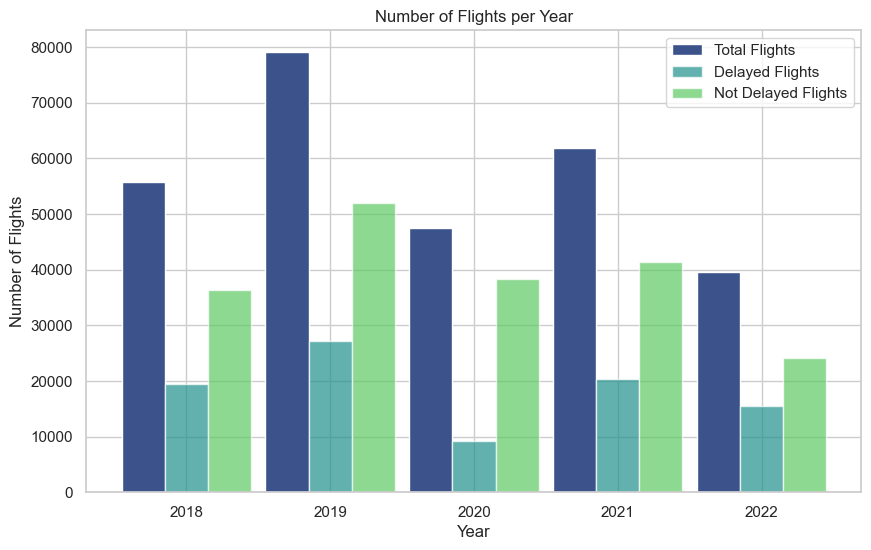

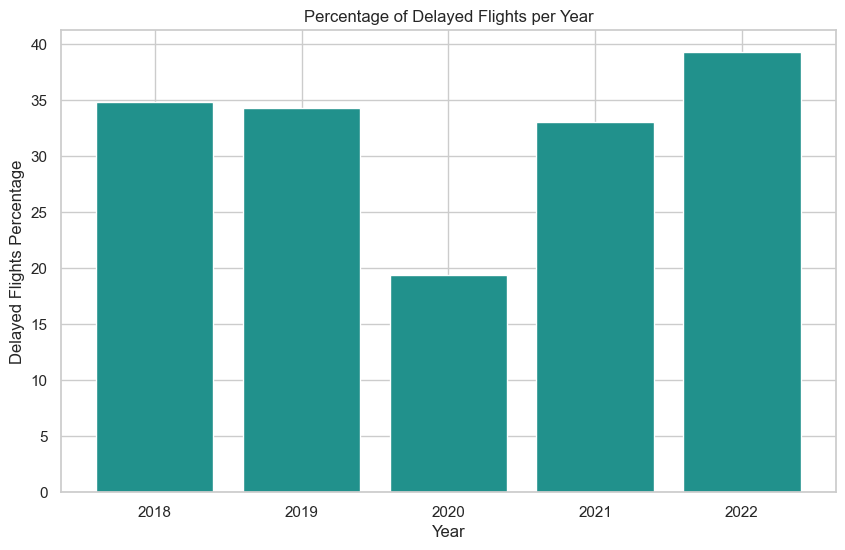

In [22]:
plot_delays(flights, 'Year', 'Year')

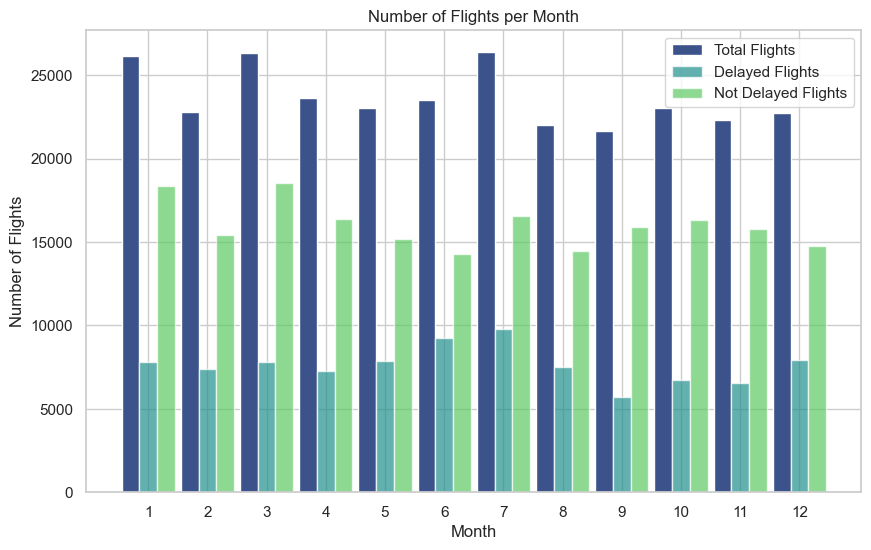

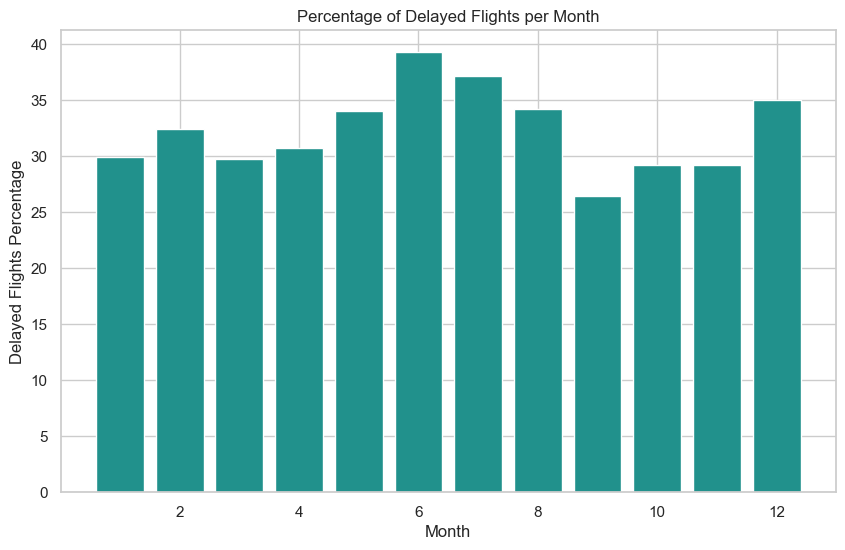

In [23]:
plot_delays(flights, 'Month', 'Month')

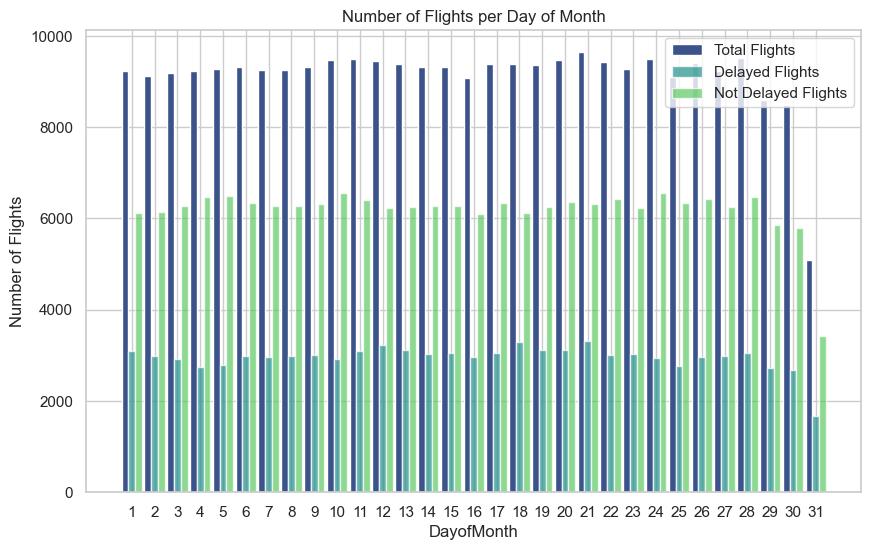

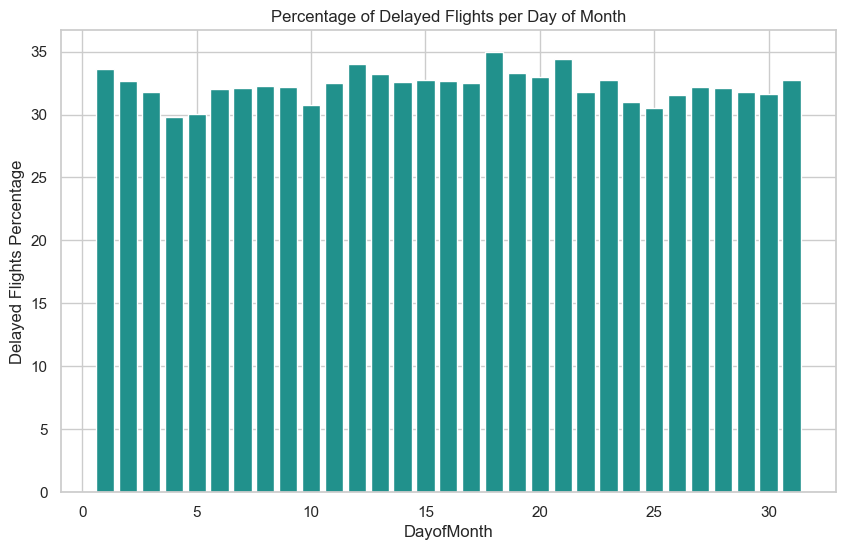

In [24]:
plot_delays(flights, 'DayofMonth', 'Day of Month')

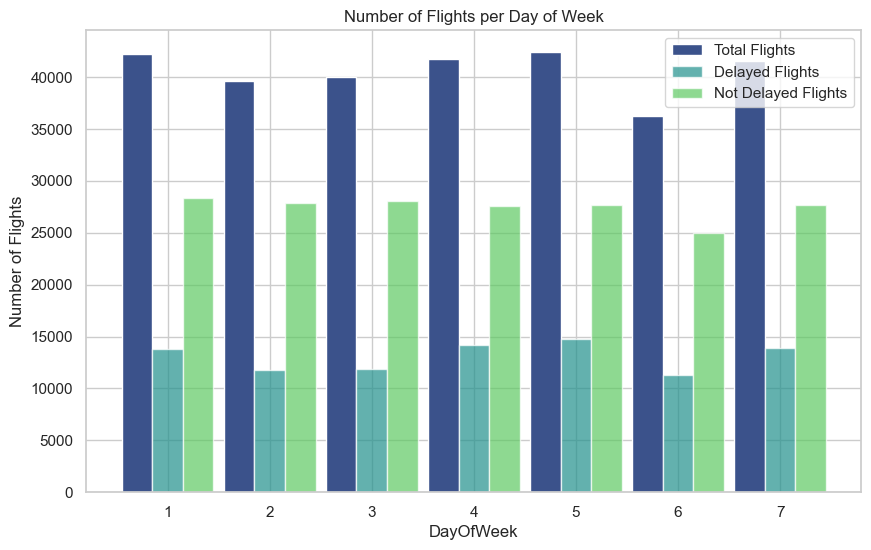

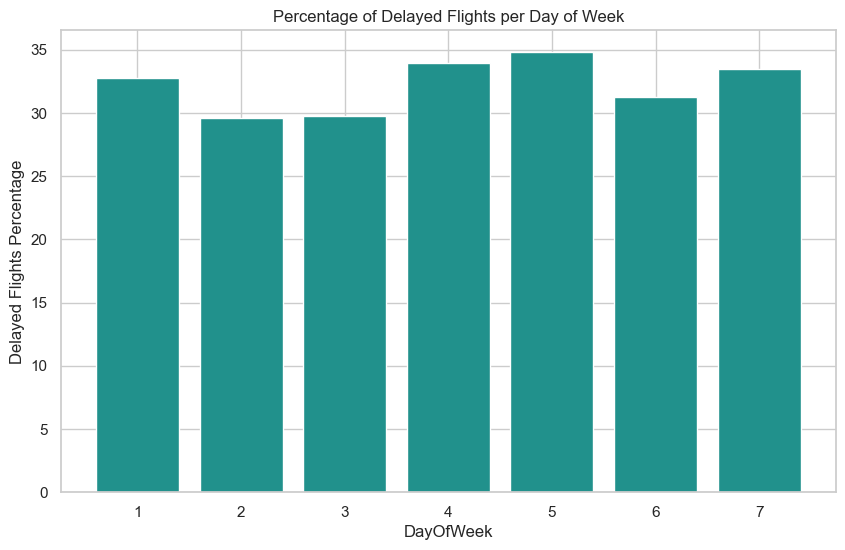

In [25]:
plot_delays(flights, 'DayOfWeek', 'Day of Week')

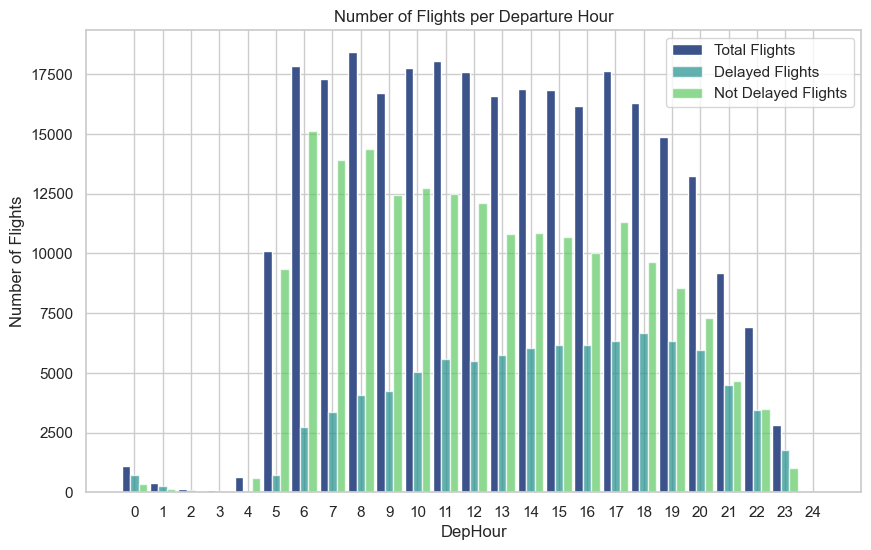

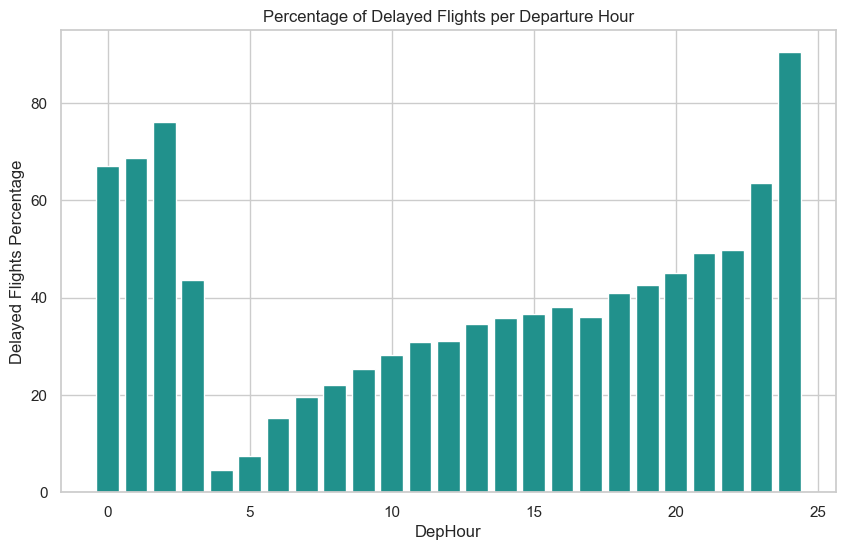

In [26]:
plot_delays(flights, 'DepHour', 'Departure Hour')

Airline

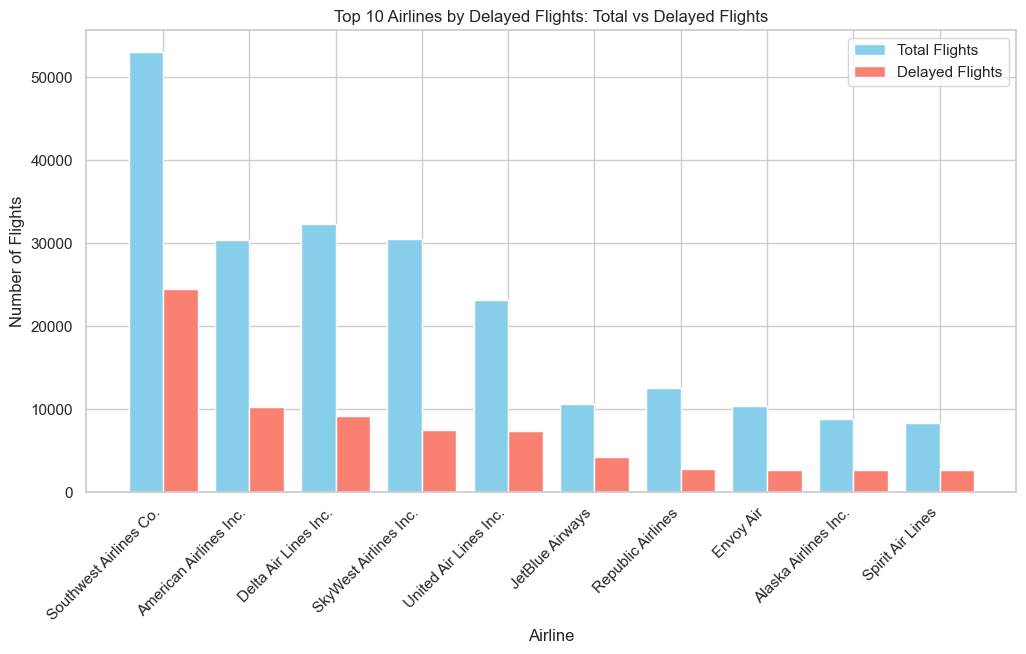

In [27]:
# Contar a frequência das companhias aéreas (todos os voos)
airline_counts = flights['Airline'].value_counts()

# Contar a frequência das companhias aéreas (voos atrasados)
delayed_flights = flights[flights['IsDelayed']]
delayed_airline_counts = delayed_flights['Airline'].value_counts()

# Ordenar as companhias aéreas pela contagem de voos atrasados
sorted_delayed_airlines = delayed_airline_counts.sort_values(ascending=False).head(10).index

# Frequência total de voos nas 10 principais companhias aéreas ordenadas por voos atrasados
total_counts_sorted = airline_counts[sorted_delayed_airlines]

# Frequência de voos atrasados nas 10 principais companhias aéreas
delayed_counts_sorted = delayed_airline_counts[sorted_delayed_airlines]

# Plotar os dados
plt.figure(figsize=(12, 6))
width = 0.4  # largura das barras

# Gráfico de barras agrupadas
plt.bar(sorted_delayed_airlines, total_counts_sorted, width=width, label='Total Flights', align='center', color='skyblue')
plt.bar([x + width for x in range(len(sorted_delayed_airlines))], delayed_counts_sorted, width=width, label='Delayed Flights', align='center', color='salmon')

# Configurações do gráfico
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.title('Top 10 Airlines by Delayed Flights: Total vs Delayed Flights')
plt.xticks([x + width / 2 for x in range(len(sorted_delayed_airlines))], sorted_delayed_airlines, rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

Localização

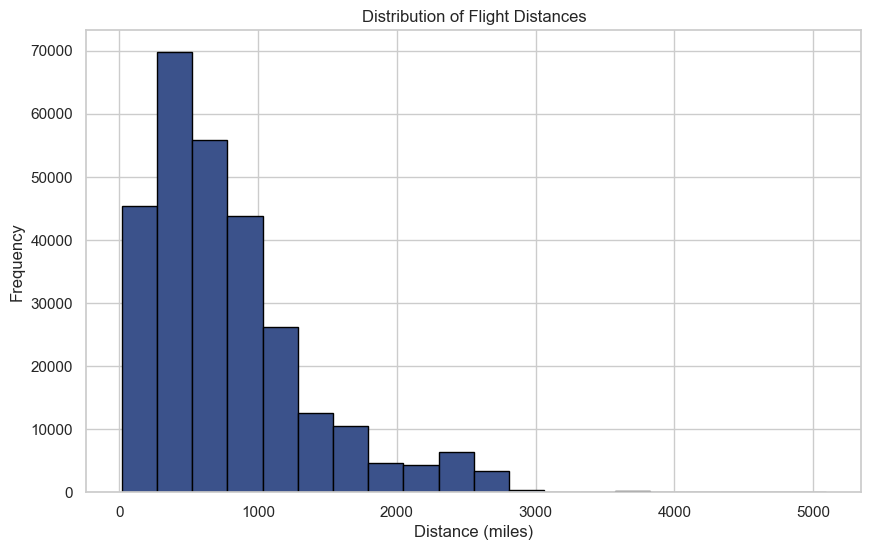

count    283650.000000
mean        781.391793
std         582.306699
min          16.000000
25%         355.000000
50%         628.000000
75%        1018.000000
max        5095.000000
Name: Distance, dtype: float64


In [28]:
# Análise de distribuição das distâncias dos voos
plt.figure(figsize=(10, 6))
plt.hist(flights['Distance'], bins=20, edgecolor='black', color=palette[0])
plt.title('Distribution of Flight Distances')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.show()
print(flights['Distance'].describe())

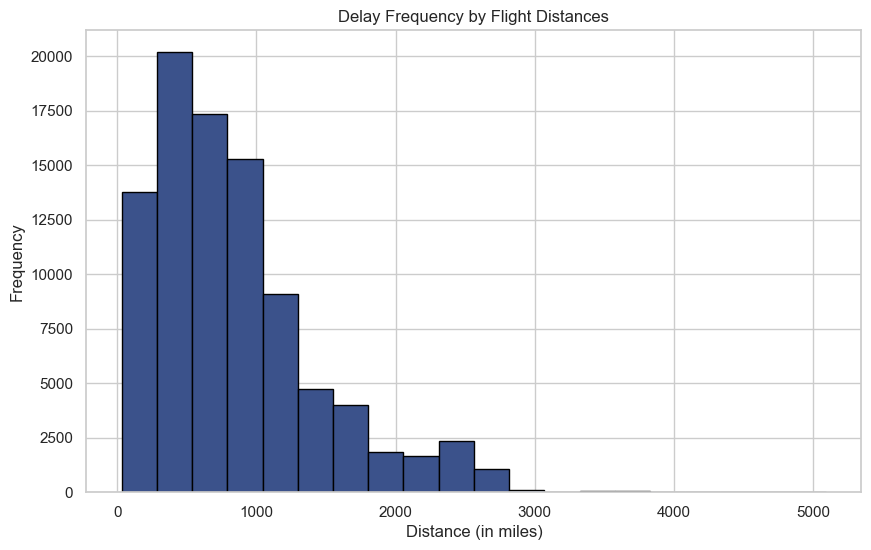

Coeficiente de Correlação de Pearson: 0.0666821188265843


In [29]:
# Plotar o histograma
plt.figure(figsize=(10, 6))
plt.hist(delayed_flights['Distance'], bins=20, edgecolor='black', color=palette[0])
plt.title('Delay Frequency by Flight Distances')
plt.xlabel('Distance (in miles)')
plt.ylabel('Frequency')
plt.show()

# Calcular o coeficiente de correlação de Pearson
correlation = flights['Distance'].corr(flights['IsDelayed'])
print("Coeficiente de Correlação de Pearson:", correlation)

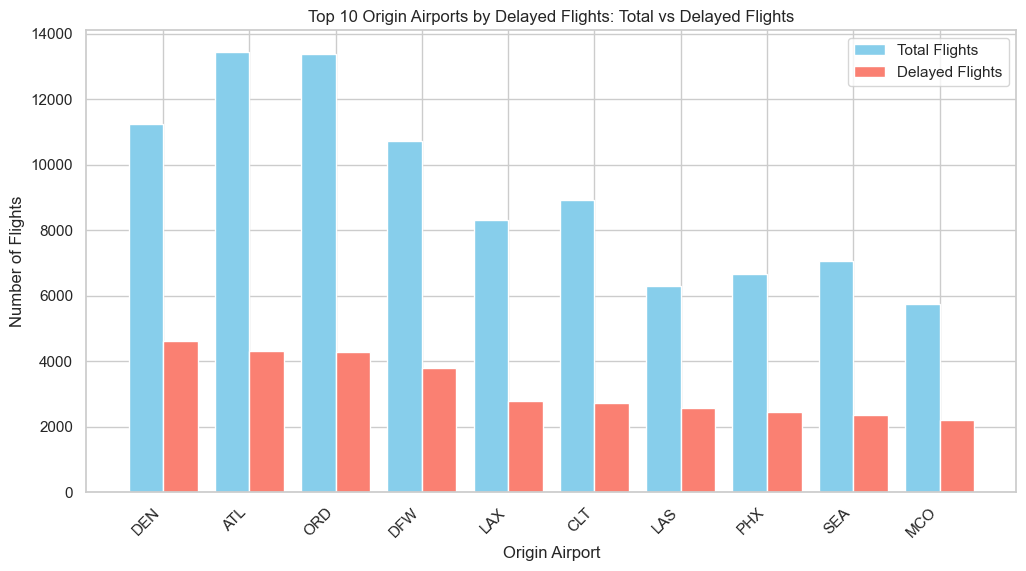

In [30]:
# Contar a frequência dos aeroportos de origem (todos os voos)
origin_counts = flights['Origin'].value_counts()

# Contar a frequência dos aeroportos de origem (voos atrasados)
delayed_flights = flights[flights['IsDelayed']]
delayed_origin_counts = delayed_flights['Origin'].value_counts()

# Ordenar os aeroportos de origem pela contagem de voos atrasados
sorted_delayed_origins = delayed_origin_counts.sort_values(ascending=False).head(10).index

# Frequência total de voos nos 10 principais aeroportos de origem ordenados por voos atrasados
total_counts_sorted = origin_counts[sorted_delayed_origins]

# Frequência de voos atrasados nos 10 principais aeroportos de origem
delayed_counts_sorted = delayed_origin_counts[sorted_delayed_origins]

# Plotar os dados
plt.figure(figsize=(12, 6))
width = 0.4  # largura das barras

# Gráfico de barras agrupadas
plt.bar(sorted_delayed_origins, total_counts_sorted, width=width, label='Total Flights', align='center', color='skyblue')
plt.bar([x + width for x in range(len(sorted_delayed_origins))], delayed_counts_sorted, width=width, label='Delayed Flights', align='center', color='salmon')

# Configurações do gráfico
plt.xlabel('Origin Airport')
plt.ylabel('Number of Flights')
plt.title('Top 10 Origin Airports by Delayed Flights: Total vs Delayed Flights')
plt.xticks([x + width / 2 for x in range(len(sorted_delayed_origins))], sorted_delayed_origins, rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

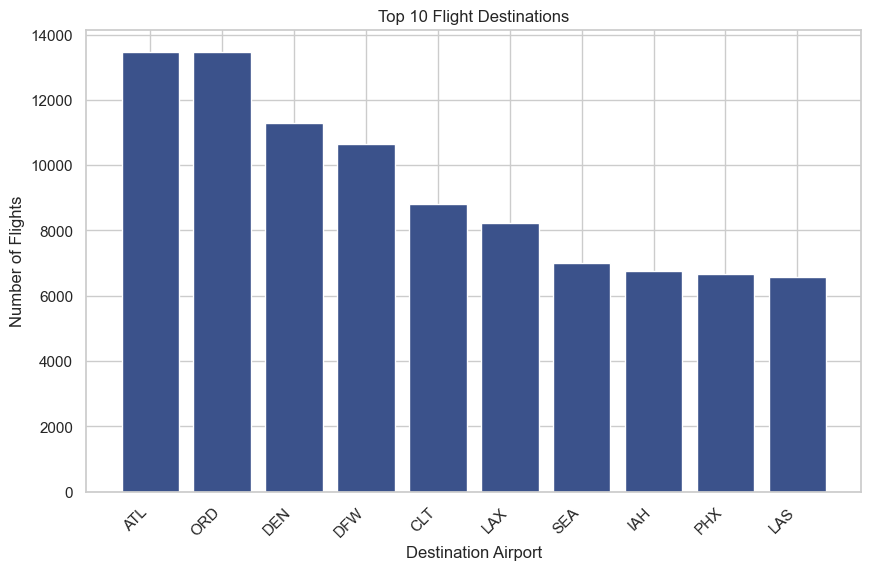

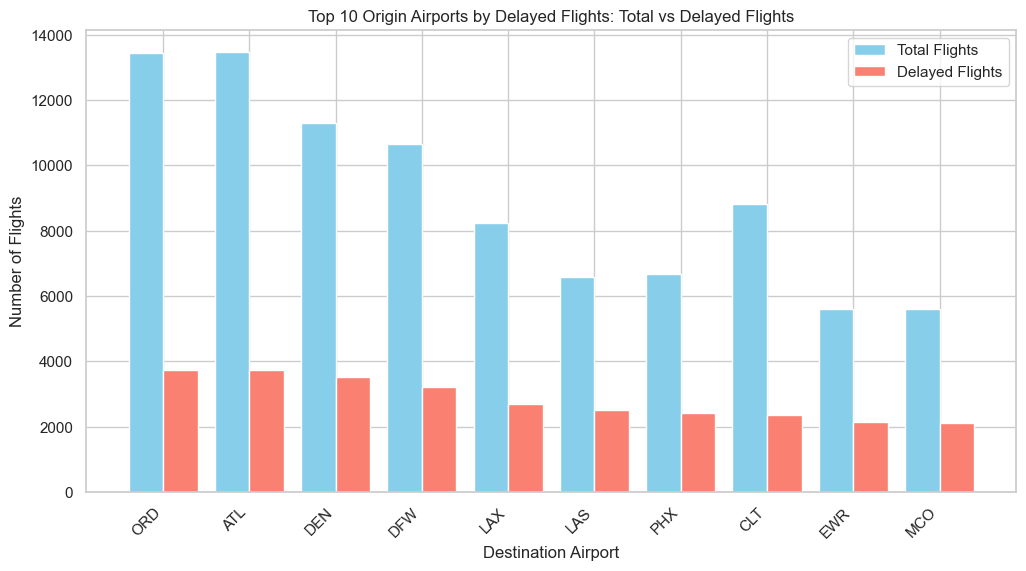

In [31]:
# Análise dos aeroportos de destino
dest_counts = flights['Dest'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(dest_counts.index[:10], dest_counts.values[:10], color=palette[0])
plt.title('Top 10 Flight Destinations')
plt.xlabel('Destination Airport')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45, ha='right')
plt.show()

# Contar a frequência dos aeroportos de destino (todos os voos)
dest_counts = flights['Dest'].value_counts()

# Contar a frequência dos aeroportos de destino (voos atrasados)
delayed_flights = flights[flights['IsDelayed']]
delayed_dest_counts = delayed_flights['Dest'].value_counts()

# Ordenar os aeroportos de destino pela contagem de voos atrasados
sorted_delayed_dest = delayed_dest_counts.sort_values(ascending=False).head(10).index

# Frequência total de voos nos 10 principais aeroportos de destino ordenados por voos atrasados
total_counts_sorted = dest_counts[sorted_delayed_dest]

# Frequência de voos atrasados nos 10 principais aeroportos de destino
delayed_counts_sorted = delayed_dest_counts[sorted_delayed_dest]

# Plotar os dados
plt.figure(figsize=(12, 6))
width = 0.4  # largura das barras

# Gráfico de barras agrupadas
plt.bar(sorted_delayed_dest, total_counts_sorted, width=width, label='Total Flights', align='center', color='skyblue')
plt.bar([x + width for x in range(len(sorted_delayed_dest))], delayed_counts_sorted, width=width, label='Delayed Flights', align='center', color='salmon')

# Configurações do gráfico
plt.xlabel('Destination Airport')
plt.ylabel('Number of Flights')
plt.title('Top 10 Origin Airports by Delayed Flights: Total vs Delayed Flights')
plt.xticks([x + width / 2 for x in range(len(sorted_delayed_dest))], sorted_delayed_dest, rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

Encerrar Spark

In [32]:
spark.stop()